# Chapter 4: Neural Nets

In [1]:
# Chapter imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_gamma_deviance
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import tensorflow as tf
from tensorflow import keras
from keras import layers, backend as K

from utils import KerasRegressor  # from utils.py

## Exercise 1

In [2]:
diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")

# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"].astype("float32"), test_size=0.2, random_state=49
)

# Data preprocessing pipeline
ord_vars = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("numeric", "passthrough", ["carat"]),
            ("ordinal", OrdinalEncoder(categories=ord_levels), ord_vars),
        ],
        verbose_feature_names_out=False,
    ),
    StandardScaler(),
).set_output(transform="pandas")

X_train = preprocessor.fit_transform(df_train)
X_test = preprocessor.transform(df_test)
X_test[0:2]  # Check

,carat,cut,color,clarity
2014,-0.185796,0.810577,-0.353796,-1.785901
21245,1.480427,1.706622,0.821629,0.640050


In [3]:
# Modeling
def loss_gamma(y_true, y_pred):
    return -K.log(y_true / y_pred) + y_true / y_pred


inputs = keras.Input(shape=4)
x = layers.Dense(30, activation="tanh")(inputs)
x = layers.Dense(15, activation="tanh")(x)
outputs = layers.Dense(1, activation="exponential")(x)

keras_model = keras.Model(inputs=inputs, outputs=outputs)

keras_model.compile(
    loss=loss_gamma,
    optimizer=keras.optimizers.Adam(learning_rate=0.002),
)

cb = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]

tf.random.set_seed(873)

history = keras_model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=400,
    validation_split=0.2,
    callbacks=cb,
    verbose=0,
)

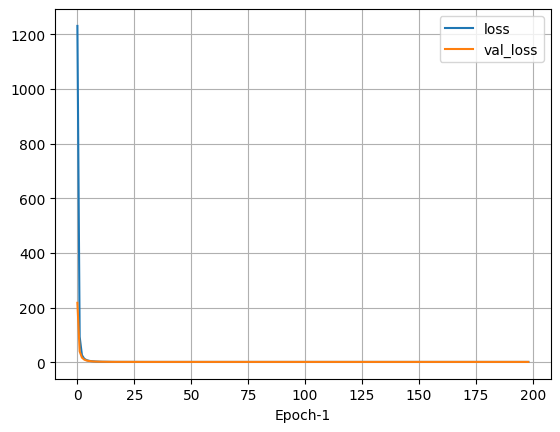

In [4]:
# Plot RMSE over epochs
_ = pd.DataFrame(history.history).filter(like="loss").plot(xlabel="Epoch-1", grid=True)


In [5]:
# Interpretation
dummy = DummyRegressor().fit(X_train, y_train)

d0, d = (
    mean_gamma_deviance(y_test, mod.predict(X_test)) for mod in (dummy, keras_model)
)
print(f"% deviance explained: {(d0 - d) / d0:.2%}")

338/338 [==============================] - 0s 714us/step
% deviance explained: 98.42%


338/338 [==============================] - 0s 538us/step


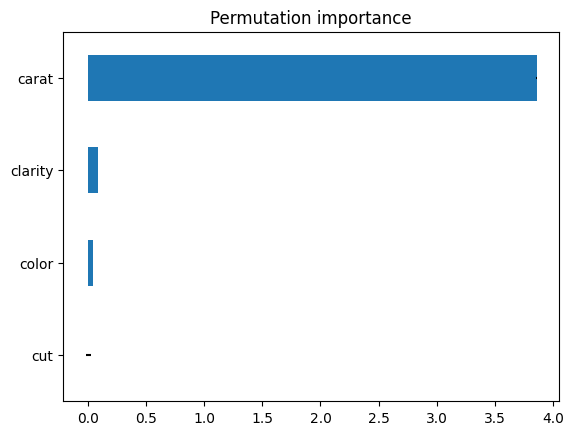

In [6]:
features = X_test.columns

imp = permutation_importance(
    keras_model,
    X=X_test,
    y=y_test,
    n_repeats=4,
    random_state=46,
    scoring="neg_mean_gamma_deviance",
)

_ = (
    pd.Series(imp["importances_mean"], index=features)
    .sort_values()
    .plot(kind="barh", xerr=imp["importances_std"], title="Permutation importance")
)


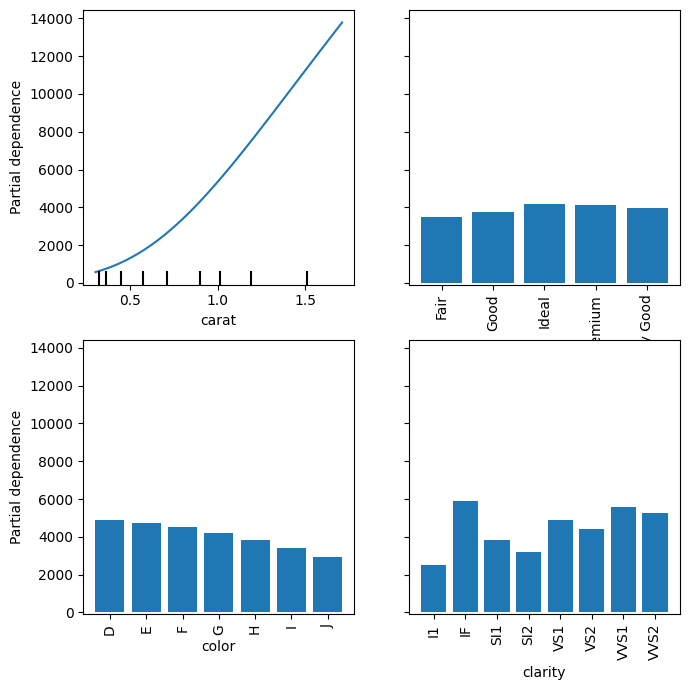

In [7]:
# To see the original feature values, we build a Scikit-Learn-like pipeline
model = KerasRegressor(make_pipeline(preprocessor, keras_model))

fig, axes = plt.subplots(figsize=(7, 7))

PartialDependenceDisplay.from_estimator(
    model,
    features=features,
    categorical_features=ord_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()


## Exercise 2

See lecture notes for a solution with embeddings